<a href="https://colab.research.google.com/github/lingtouyangLeo/dl_project3/blob/main/dl_project3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import numpy as np
import json
import os
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

In [2]:
# Load pretrained ResNet-34
model = torchvision.models.resnet34(weights='IMAGENET1K_V1')
model.eval()
model = model.cuda()

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 183MB/s]


Set dataset path

In [3]:
from google.colab import drive
drive.mount('/content/drive')
dataset_path = "/content/drive/MyDrive/dl_project3/TestDataSet"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
mean_norms = [0.485, 0.456, 0.406]
std_norms = [0.229, 0.224, 0.225]
plain_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_norms, std=std_norms)
])

dataset = datasets.ImageFolder(root=dataset_path, transform=plain_transforms)



In [5]:
# Load label mapping from labels_list.json
with open(os.path.join(dataset_path, "labels_list.json"), "r") as f:
    raw_labels = json.load(f)

# Build mapping: class_idx -> ImageNet index, and ImageNet index -> label name
idx_to_imagenet_idx = {}
imagenet_idx_to_label = {}
for i, item in enumerate(raw_labels):
    imagenet_index, label_name = item.split(": ")
    idx_to_imagenet_idx[i] = int(imagenet_index)
    imagenet_idx_to_label[int(imagenet_index)] = label_name

In [6]:
# Define custom dataset wrapper to relabel targets
class RelabeledDataset(torch.utils.data.Dataset):
    def __init__(self, base_dataset, idx_map):
        self.base_dataset = base_dataset
        self.idx_map = idx_map

    def __getitem__(self, index):
        image, label = self.base_dataset[index]
        new_label = self.idx_map[label]
        return image, new_label

    def __len__(self):
        return len(self.base_dataset)


In [7]:
# Create dataloader with relabeled targets
relabeled_dataset = RelabeledDataset(dataset, idx_to_imagenet_idx)
dataloader = torch.utils.data.DataLoader(relabeled_dataset, batch_size=16, shuffle=False)


# Task 1 : Evaluate pretrained ResNet-34 on the clean test dataset

In [8]:
# Evaluation function with label mapping
def evaluate_model(model, dataloader, idx_to_imagenet_idx, imagenet_idx_to_label, device='cuda'):
    model.eval()
    top1_correct = 0
    top5_correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, top5_preds = outputs.topk(5, dim=1)

            # Top-1 accuracy
            top1_preds = top5_preds[:, 0]
            top1_correct += (top1_preds == labels).sum().item()

            # Top-5 accuracy
            for i in range(labels.size(0)):
                if labels[i] in top5_preds[i]:
                    top5_correct += 1

            total += labels.size(0)

    top1_acc = top1_correct / total
    top5_acc = top5_correct / total

    print(f"Top-1 Accuracy: {top1_acc:.4f}")
    print(f"Top-5 Accuracy: {top5_acc:.4f}")
    return top1_acc, top5_acc

In [9]:
# Move the model to GPU
model = model.to('cuda')

# Run Task 1 baseline evaluation
print("Evaluating ResNet-34 on clean TestDataSet...")
top1_clean, top5_clean = evaluate_model(
    model,
    dataloader,
    idx_to_imagenet_idx,
    imagenet_idx_to_label,
    device='cuda'
)

# Save baseline result for later comparison
baseline_results = {
    "top1": top1_clean,
    "top5": top5_clean
}

Evaluating ResNet-34 on clean TestDataSet...
Top-1 Accuracy: 0.7060
Top-5 Accuracy: 0.9320


# Task 2 : Pixel-wise attacks

In [11]:

# FGSM attack implementation
def fgsm_attack(model, images, labels, epsilon):
    images.requires_grad = True
    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)
    model.zero_grad()
    loss.backward()
    grad_sign = images.grad.data.sign()
    perturbed = images + epsilon * grad_sign
    perturbed = torch.clamp(perturbed, 0, 1)  # Ensure valid pixel range
    return perturbed.detach()

# Generate Adversarial Test Set 1
epsilon = 0.02
adv_images_all = []
adv_labels_all = []

print(f"Generating adversarial examples with ε = {epsilon} ...")
model.eval()
for images, labels in tqdm(dataloader):
    images, labels = images.to('cuda'), labels.to('cuda')
    adv_images = fgsm_attack(model, images, labels, epsilon)
    adv_images_all.append(adv_images.cpu())
    adv_labels_all.append(labels.cpu())

# Combine into a new dataset
adv_images_all = torch.cat(adv_images_all)
adv_labels_all = torch.cat(adv_labels_all)
adv_dataset = TensorDataset(adv_images_all, adv_labels_all)
adv_loader = DataLoader(adv_dataset, batch_size=16, shuffle=False)

# Evaluate adversarial performance
print("Evaluating on Adversarial Test Set 1 (FGSM)...")
top1_adv, top5_adv = evaluate_model(
    model,
    adv_loader,
    idx_to_imagenet_idx,
    imagenet_idx_to_label,
    device='cuda'
)

# Save for reporting
fgsm_results = {
    "top1": top1_adv,
    "top5": top5_adv,
    "epsilon": epsilon
}

Generating adversarial examples with ε = 0.02 ...


100%|██████████| 32/32 [00:03<00:00,  9.42it/s]


Evaluating on Adversarial Test Set 1 (FGSM)...
Top-1 Accuracy: 0.2320
Top-5 Accuracy: 0.4540


Visualize 5 test cases where the original model no longer classifies as expected.

In [18]:
from torchvision.models import ResNet34_Weights

# match ID# to labels
# Load full 1000 ImageNet class names
weights = ResNet34_Weights.IMAGENET1K_V1
imagenet_1k_labels = weights.meta["categories"]

# Unified label lookup: prefer custom, fallback to ImageNet-1K
def get_label_name(class_idx):
    if class_idx in imagenet_idx_to_label:
        return imagenet_idx_to_label[class_idx]
    elif 0 <= class_idx < len(imagenet_1k_labels):
        return imagenet_1k_labels[class_idx]
    else:
        return f"ID {class_idx}"


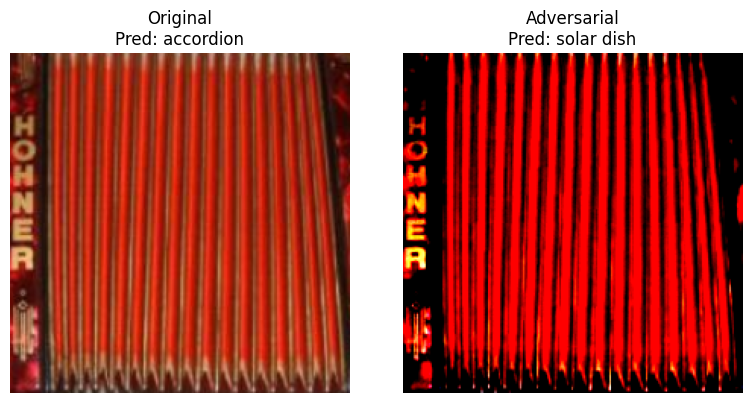

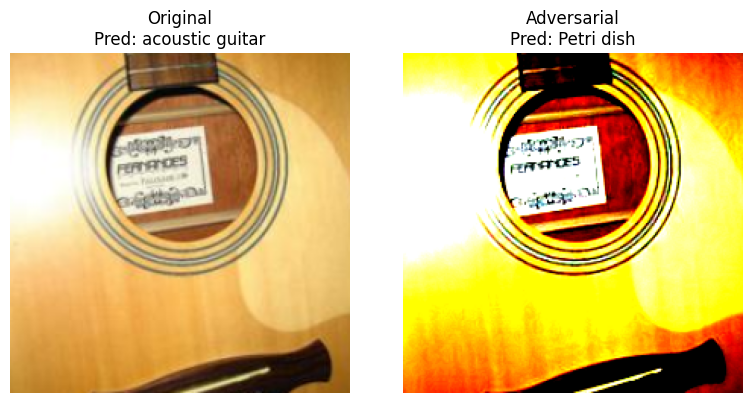

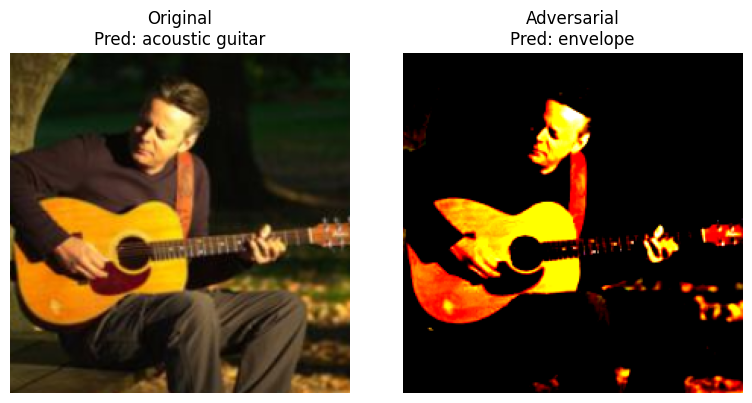

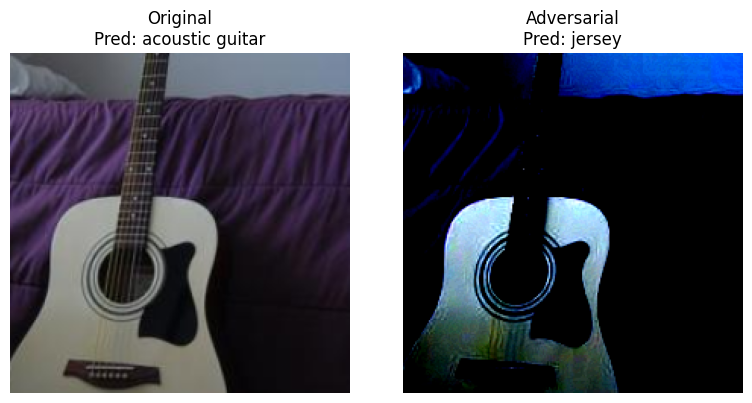

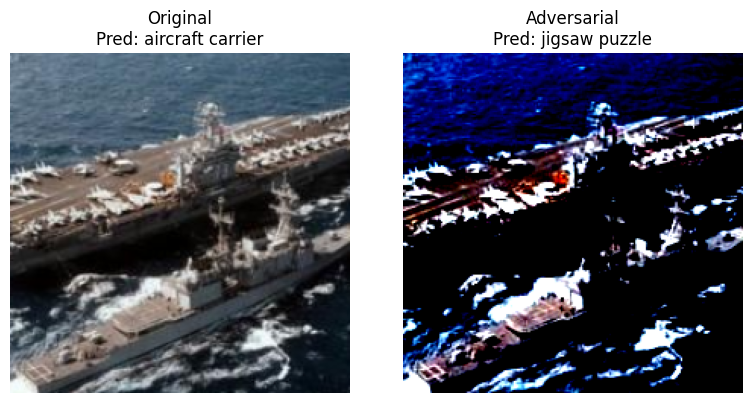

In [20]:
# Helper: denormalize the image tensor
def denormalize(img_tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    return torch.clamp(img_tensor * std + mean, 0, 1)

# Prepare to collect 5 misclassified examples
shown = 0
for i in range(len(relabeled_dataset)):
    image, true_label = relabeled_dataset[i]
    adv_image, adv_label = adv_dataset[i]

    image = image.unsqueeze(0).to('cuda')
    adv_image = adv_image.unsqueeze(0).to('cuda')

    model.eval()
    with torch.no_grad():
        clean_pred = model(image).argmax(dim=1).item()
        adv_pred = model(adv_image).argmax(dim=1).item()

    if clean_pred == true_label and adv_pred != true_label:
        fig, axs = plt.subplots(1, 2, figsize=(8, 4))
        img1 = denormalize(image.squeeze().cpu()).permute(1, 2, 0).numpy()
        img2 = adv_image.squeeze().cpu().permute(1, 2, 0).numpy()

        axs[0].imshow(img1)
        axs[0].axis('off')
        axs[1].imshow(img2)
        axs[1].axis('off')

        # Handle missing labels safely
        orig_label = get_label_name(clean_pred)
        adv_label = get_label_name(adv_pred)
        axs[0].set_title(f"Original\nPred: {orig_label}")
        axs[1].set_title(f"Adversarial\nPred: {adv_label}")

        plt.tight_layout()
        plt.show()

        shown += 1
        if shown >= 5:
            break

plt.show()

In [17]:
torch.save({
    'images': adv_images_all,
    'labels': adv_labels_all
}, 'adv_test_set_1.pt')


# Task 3 :